In [1]:
import numpy as np
import string
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.metrics import accuracy_score, RocCurveDisplay, auc, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import requests
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import statsmodels.regression.linear_model as sm
from sklearn.linear_model import LassoCV
# the code block below is directly downloading data into your drive folder. Please just run it and do not comment out.
from urllib import request
module_url = [f"https://drive.google.com/uc?export=view&id=1NJN0VmS4lWfrGQ86-glTXU_WQeFX0xHJ",
              f"https://drive.google.com/uc?export=view&id=1DGhCMqrxRy_oRZDR7cy2OFDqjI_OHydR"]
name = ['STAT.csv', 'nba.csv']
for i in range(len(name)):
    with request.urlopen(module_url[i]) as f, open(name[i],'w') as outf:
        a = f.read()
        outf.write(a.decode('ISO-8859-1'))

### Code 1

In [2]:
def sport_viz(df, *args):
    """
    Intro:
     Build a function to generate 3 different plots/graphs using Pandas, Seaborn, and Plotly.

    Functionality:
     This function allows you to generate 3 plots such as bar, box, radar for exploring and analyzing football players statistics.
     It offers flexibility in selecting the columns to visualize, aggregate the columns and also add addi parameters like plot size, color scheme, and data filtering option.

    Parameters used:
        df (pd.DataFrame): The dataframe consisting of football player's statistics.
        *args (tuple): It specifies the arguments used for the function.
             sel (str): Selects different plots such as - bar, box, and radar.
             stats (list of str): The returned list of statistics which will be plotted and visualized.
             f (func): The aggregate function for performing grouping operations.
             col (str): Selects the necessary target columns.
             addi (dict): Extra/additional parameters used in different operations addi = {'n': 2, 'figsize':[4,4], 'colormap': 'Blues', 'notch': True, 'spe_rows': []}.

             bar - It creates a barplot and applies grouping with .nlargest function.
             box - It creates a boxplot and filters data using spe_row.
             radar -It creates a radar plot filters data using spe_row and performs grouping.

            fig.update_layout - It adds adjustments such as title, xlabel, ylabel and legends to the radar-plot using plotly
            fig.update_traces - It fills the area between the lines and the origin in the radar plot

    Returns:
      Depending on the test case configuration, this function will generate three distinct types of plots: Bar, Box, and Radar, Each plot type will display the respective statistics as specified in the test case.

    """
    # Error handling for function arguments
    if len(args) != 5:
        return 'Sorry, incorrect number of arguments provided. Please check and try again!'

    # Defining the arguments
    sel, col, stats, f, addi = args

    # Defining default settings based on question's requirement
    n = addi.get('n', 2)
    figsize = addi.get('figsize', [4, 4])
    colormap = addi.get('colormap', 'Blues')
    notch = addi.get('notch', True)
    spe_rows = addi.get('spe_rows', [])

    # Creates a bar plot and performs groupuing with nth largest.
    if sel == 'bar':
        if spe_rows:
            df = df[df[col].isin(spe_rows)]

        grp_bar = df.groupby(col)[stats].agg(f).reset_index()
        n_th_largest = grp_bar.nlargest(addi['n'], stats[0], keep='all')
        ax = n_th_largest.plot(kind='bar', x=col, figsize=addi['figsize'], colormap=addi['colormap'])

        # Adding the figure title, xlabel, ylabel, legend and rotation.
        plt.title(f'Bar graph for {col}')
        plt.ylabel('Player Values')
        plt.xlabel(col)
        plt.xticks(rotation=45)
        plt.legend(title="Statistics")
        plt.show() # Used to present the visualization in the notebook file
        return ax

    # Creates a box plot and perfoms filtering on spe_rows
    elif sel == 'box':
        # Filter DataFrame based on spe_rows
        filtered_df = df[df[col].isin(addi['spe_rows'])] if addi['spe_rows'] else df

        # Check if any data is available after filtering
        if not filtered_df.empty:
            plt.figure(figsize=addi['figsize'])  # Set figure size
            sns.boxplot(data=filtered_df[stats], palette=addi['colormap'], notch=addi['notch'])
            plt.title(f'Box Plot') # Set the title of the box plot
            plt.xlabel(col)
            plt.ylabel('Statistics')
            plt.xticks(rotation=45) # Set the rotation of xticks to replicate similar output as in test case
            plt.show() # Used to present the visualization in the notebook file
        else:
            print('Apologies, no available data found after filtering')

    # Creates a radar plot and performs groupuing with nth largest.
    elif sel == 'radar':
        # Filter DataFrame based on spe_rows if provided
        if addi['spe_rows']:
            df = df[df[col].isin(addi['spe_rows'])]

        if not df.empty:
            # limiting the number of players displayed to avoid overcrowding.
            grp_radar_df = df.groupby(col)[stats].agg(f).reset_index()
            # Ensuring consistent length of data for the radar chart
            df_results = grp_radar_df.melt(id_vars=[col], value_vars=stats, var_name='Stat', value_name='Value') # melt the df_results
            top_n = df_results[df_results[col].isin(grp_radar_df.nlargest(addi['n'], stats[0])[col])]
            fig = px.line_polar(top_n, r='Value', theta='Stat', color=col, line_close=True)
            fig.update_traces(fill='toself')
            fig.update_layout(width=addi['figsize'][0] * 100, height=addi['figsize'][1] * 100)
            fig.show() # Used to present the visualization in the notebook file
        else:
            print("Error No data is available for the selected players, Please try again with other criteria's.") # Error handling if no fulfilled criteria in test case

### Test Case Code 1

In [5]:
df = pd.read_csv('STAT.csv')
col = 'Player'
stats = ['Goals', 'AerWon%', 'SoT%', 'PasTotCmp%']
f = 'sum'
additional = {'n':10, 'figsize':[10,5], 'colormap':'viridis', 'notch':True, 'spe_rows': []}
fig1 = sport_viz(df, 'radar', col, stats, f, additional)

### Code 2

In [7]:
def grammy_scraper(url, start, end, PerfQuery):
    """
    This function performs web scraping of data from the Wikipedia page dedicated to the Grammy Award for Best Rock Song-(https://en.wikipedia.org/wiki/Grammy_Award_for_Best_Rock_Song),
    it retrieves information about Grammy Award wins for specified performers over various years.

    Parameters used:
        url (str): The URL of the Wikipedia page containing the Grammy Award data to be scraped.
        start (int): The starting year for the search window looking for Grammy data that starts from this year.
        end (int): The ending year for the search window looking for Grammy data that end by this year.
        PerfQuery (str): The performer's name to search for in the Grammy data table, since the function is case-insensitive it will search for the performer in any case format.

   Functionality:
   -response - we Send a GET request to specified URL
   -soup - we use 'soup' parse the HTML content of the page using BeautifulSoup library
   -cols - we define the columns from which the dataframe will be created
   -row - Select all table rows in the Grammy Awards table
   -year - Extract the year from the row's header cell.
   -winner - Find the winner and their work
   -data.append - Append the winner's information to the data list
   -df_performers - Filter DataFrame for the specified performer and count nominations and wins
   -Print a summary of the performer's nominations and wins within the specified date range.



    Returns:
         (DataFrame): It returns a DataFrame containing all the filtered Grammy data of nominations and wins for the specified performer over the years, This DataFrame will include columns such as [ 'Year', 'Performer', 'Work', and 'Winner'].
          Print - It also returns a print statment below the dataframe for example: Between years 2001 and 2012, U2 has been nominated for the Grammy Awards 5 times. Among those nominations, U2 won the award 2 times.
  Notes:

    BeautifulSoup Library This function utilizes the BeautifulSoup library to scrape data from Wikipedia about Grammy Award-winning performers, it extracts relevant details and returns a filtered DataFrame based on specified criteria.
    """
    # Send a GET request to the specified URL
    response = requests.get(url)
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')

    # Define the columns of the DataFrame to be created
    cols = ['Year', 'Performer', 'Work', 'Winner']

    data = []

    # Select all table rows in the Grammy Awards table, skipping the header row
    rows_in_table = soup.select('div.mw-content-ltr.mw-parser-output table.wikitable tbody tr')[1:]

    for row in rows_in_table:
        # Extract the year from the row's header cell
        year_in_table = row.select_one('th')
        if year_in_table:
            text = year_in_table.get_text().strip()
            if text.isdigit():
                year = int(text)
                if start <= year <= end:
                    # Process only rows within the specified date range
                    find_winners = row.select_one('td:nth-child(4)')
                    winner_in_table = row.select_one('td:nth-child(3)')
                    if find_winners and winner_in_table:
                        winner = find_winners.get_text().strip()
                        winnerwork = winner_in_table.get_text().strip()
                        data.append([year, winner, winnerwork, True])

                        # Find all nominees within the list in the 5th column
                        list_of_nominees = row.select_one('td:nth-child(5) div ul')
                        if list_of_nominees:
                            for nominee in list_of_nominees.find_all('li'):
                                nominee_word = nominee.get_text()
                                if '–' in nominee_word:
                                    nominee_parts = nominee_word.split("–", 1)[1].strip()
                                    if nominee_parts.count('" (') == 1:
                                        nomineework, nominee = nominee_parts.split('" (')
                                        data.append([year, nominee.strip(),nomineework.strip(), False])

    # Create a DataFrame with the collected data
    df = pd.DataFrame(data, columns=cols)
    print(df.head(),'\n')

    # Filter DataFrame for the specified performer and count nominations and wins
    df_performers = df[df['Performer'].str.contains(PerfQuery, case=False, na=False)]
    nominated = len(df_performers)
    num_times_won = len(df_performers[df_performers['Winner'] == True])

    # Print summary information
    print(f"Between years {start} and {end}, {PerfQuery} has been nominated for the Grammy Awards {nominated} times. Among those nominations, {PerfQuery} won the award {num_times_won} times.")

    return df

### Test case for Code 2

In [8]:
start = 2001
end = 2012
PerfQuery = 'U2'
url = 'https://en.wikipedia.org/wiki/Grammy_Award_for_Best_Rock_Song'
df = grammy_scraper(url, start, end, PerfQuery)

   Year               Performer                   Work  Winner
0  2001                   Creed  "With Arms Wide Open"    True
1  2001           3 Doors Down)            "Kryptonite   False
2  2001          Lenny Kravitz)                 "Again   False
3  2001        Matchbox Twenty)                  "Bent   False
4  2001  Red Hot Chili Peppers)       "Californication   False 

Between years 2001 and 2012, U2 has been nominated for the Grammy Awards 5 times. Among those nominations, U2 won the award 2 times.


### Code 3

In [10]:
def Fextractor(*args):
    """
    This function performs feature selection for the most relevant/important features from in your dataset,
    It simplifies the process of choosing between different feature selection techniques such as: variance thresholding, importance, Pearson correlation, and LASSO regularization allowing a tailored approach based on the dataset's characteristics
and the specific modeling objectives.

    Parameters used:
        *args (tuple): It specifies the arguments used for the function.
        df (dataset): It consists of the data from which different selection techniques will be performed (nba.csv)
        target (str): The Independent variable/ outcome variable
        sel (str): It is used to selects different feature selection techniques such as ['var', 'imp', 'cor', 'lasso']:
                    'var': It cuts off features with low variance below a specified threshold.
                    'imp': Finds the features that are most relevant and important.
                    'cor': Finds which features are highly correlated with your target variable.
                    'lasso': It effectively reduces the number of features by constraining the size of the coefficients, which helps to enhance model interpretability.
        threshold' - List of thresholds for 'var', 'imp', 'cor'.
       'imp_func' - The model/function class to use for computing the feature importance in 'imp'.
        'cv = 5' -  The number of folds in cross-validation.


    Returns:
        This function returns a list of columns which consists of the most important features which are meticulously filtered based on the methods specified in the test case.
    """
    if len(args) != 4:
        return 'Sorry, incorrect number of arguments provided. Kindly check the required number of arguments and try again!'

    df, target, sel, addi = args

    # Drop rows with any NaN values in the dataframe
    df = df.dropna()

    # Drop non-numeric columns for feature selection methods that need numeric input
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target in num_cols:
        num_cols.remove(target)

    if target not in df.columns:
        return 'The target variable specified is not in the dataset.'

    X = df[num_cols] # Independent variable
    y = df[target] # Dependent Variable

    # Variance Thresholding
    if sel == 'var':
        threshold = addi['threshold'][0]
        select = VarianceThreshold(threshold=threshold) # Selecting the threshold
        select.fit(X)  # Fitting the variable
        features = X.columns[select.get_support(indices=True)].tolist()

    # Permutation Importance
    elif sel == 'imp':
        threshold = addi['threshold'][1]
        model_imp = addi['imp_func']()
        model_imp.fit(X, y)
        results_imp = permutation_importance(model_imp, X, y, n_repeats=30)
        features = X.columns[results_imp.importances_mean >= threshold].tolist()

    # Pearson Correlation
    elif sel == 'cor':
        threshold = addi['threshold'][2]
        corr_mat = df[num_cols + [target]].corr().abs()
        corr_target = corr_mat[target].drop(target)
        features = corr_target[corr_target > threshold].index.tolist()

    # LASSO Regularization
    elif sel == 'lasso':
        # cv=5 number of folds in cross-validation
        model_lasso = LassoCV(cv=5, random_state=42) # random_state= 42 for reproducbility
        model_lasso.fit(X, y)
        features = X.columns[model_lasso.coef_ != 0].tolist()
    else:
      return 'The Feature selection technique specified is incorrect, please use the correct feature selection technique'

    return features

### Test case for Code 3

In [11]:
df = pd.read_csv('nba.csv')
target = '5yrs'
sel = 'imp'
addi = {'threshold':[0.5, 0.01, 0.15, 0], 'imp_func':LinearRegression}
Fextractor(df, target, sel, addi)

['games_played',
 '3_point_scored',
 '3_point_attempted',
 'free_throws_scored',
 'free_throws_attempted',
 'offensive_rebounds']

### Code 4

In [12]:
def prediction_perf(*args):
    """
    Intro: The function is used to build, train, test and evaluate a logistic regression model and its perdictions for target variable of '5yrs' by using each of the previously implemented feature selection techniques

    Parameters used:
    - df (DataFrame): The dataset used to build the model.
    - target (str): The dependent variable/target column to be predicted.
    - addi (dict): A dictionary storing technique-specific additional variables.

    Functionality:
    - dropna() - drops NaN values, subsequently we can also treat these missing values using Mean or Median
    - for method in methods- Iterates over different feature selection methods ('var', 'imp', 'cor', 'lasso'), For each method, it uses the Fextractor function to select relevant features.
    - train_test_split - splits the data into training and testing sets using train_test_split from SKlearn
    - fit() - Fits the LogisticRegression model(Classification model) on the training data
    - y_pred, y_pred_proba - Makes predictions on the test data and evaluates the performance using metrics like MSE, accuracy, and AUC.
    - results_plot - Stores the results in a list
    - df_results - creates a DataFrame with the results stored
    - plt.plot(fpr, tpr, label=f"{method} (AUC = {roc_auc:.3f})") - Plots the ROC (Receiver Operating Characteristic) curves for each model.

    Returns:
    - DataFrame: It returns a DataFrame containing the performance metrics such as Accuracy(ACC% Accuracy Percentage), MSE(Mean Squared Error) and AUC(Area Under the Curve)
    - It also plots the ROC curve with the different feature selection techniques

    Note:
      The function does not employ feature scaling (e.g., StandardScaler) since the library was not imported in the test case setup. The absence of scaling is very evident which, affects model convergence when running the test case by potential convergence warnings when the model and hits the iteration limit before fully converging.
      I have used 'max_iter = 1000' to see if it helps but no change to the convergence warning.

    """

    # Unpack the arugments and assign to args
    df, target, addi = args

    # Drops the NAN values in the dataframe
    df = df.dropna()

    # Set the size of ROC curves plot
    plt.figure(figsize=(10, 7))

    # results list to be returned
    results_plot = []

    # Methods from Fextractor for feature selection
    methods = ['var', 'imp', 'cor', 'lasso']

    for method in methods:
        #  Intergrate the Fextractor function to select features based on the method
        selected_features = Fextractor(df, target, method, addi)
        if not selected_features:
            # If no features were returned
            print(f"No features selected using method: {method}")
            continue

        X = df[selected_features]
        y = df[target]

        # Splitting the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Fitting Logistic Regression
        model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
        model.fit(X_train, y_train)

        # Predictions and Evaluations
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        mse = np.mean((y_pred - y_test.values) ** 2)  # Calculate MSE manually

        acc = accuracy_score(y_test, y_pred)  # Calculate accuracy

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # ROC curve
        roc_auc = auc(fpr, tpr)  # AUC score

        # Storing results
        results_plot.append({'Model': method, 'ACC%': acc * 100, 'MSE': mse, 'AUC': roc_auc})

        # Create a DataFrame with results and print it
        df_results = pd.DataFrame(results_plot)

        # Plot ROC curve for this model
        plt.plot(fpr, tpr, label=f"{method} (AUC = {roc_auc:.3f})")
    print(df_results, '\n')

    # Finalize and show the ROC plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Feature Selection Methods')
    plt.legend(loc="lower right")
    plt.show()

    return df_results

### Test case for code 4

   Model       ACC%       MSE       AUC
0    var  69.712352  0.302876  0.752110
1    imp  70.389171  0.296108  0.754431
2    cor  69.373942  0.306261  0.753860
3  lasso  70.558376  0.294416  0.753890 



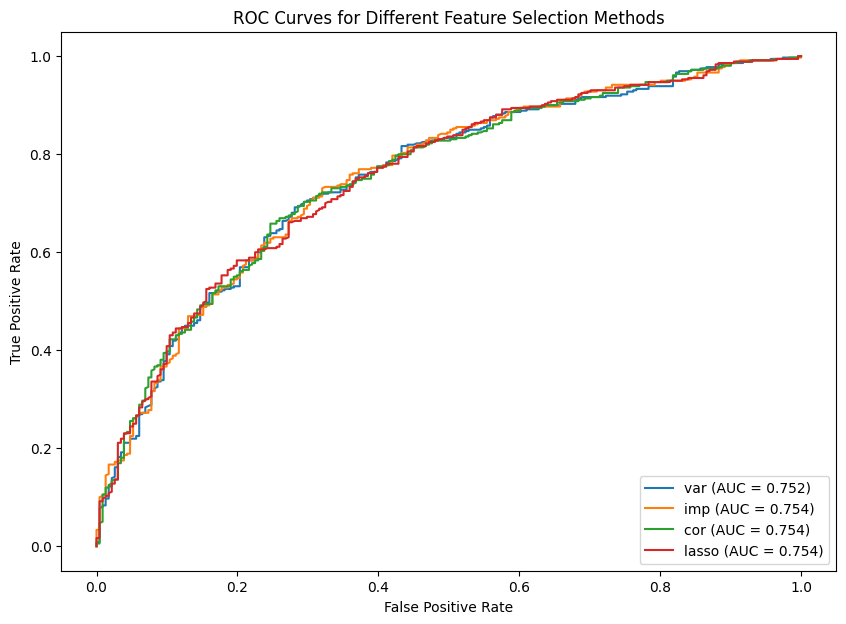

In [13]:
df = pd.read_csv('nba.csv')
target = '5yrs'
addi = {'threshold':[0.5, 0.01, 0.15, 0], 'imp_func':LinearRegression}
df_results = prediction_perf(df, target, addi)